<a href="https://colab.research.google.com/github/minshyee/RecoSyS/blob/main/RecomSyS_using_deeplearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Matrix Factorization(MF)을 신경망으로 변환하기

In [ ]:
import pandas as pd

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dot, Add, Flatten
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD, Adamax

In [ ]:
r_cols = ['user_id','movie_id','rating','timestamp']
data_dic = '/content/drive/MyDrive/Recosys/Data/u.data'
ratings = pd.read_csv(data_dic,
                      names=r_cols,
                      sep='\t',
                      encoding='latin-1')

ratings_train, ratings_test = train_test_split(ratings, test_size=0.2, shuffle=True, random_state=2021)

In [ ]:
# latent vector 
k = 200

mu = ratings_train.rating.mean() # 전체 평균

# user가 몇 명이고, 영화가 몇 개인지 세기
M = ratings.user_id.max() + 1 # +1은 bias term의 크기
N = ratings.movie_id.max() + 1

def RMSE(y_true, y_pred):
  return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

Keras Layer에 신경망을 구성하기 위한 코드

In [18]:
# 사용자와 아이템의 입력 크기 미리 지정 -> 왜 (1,)?
user = Input(shape=(1,))
item = Input(shape=(1,))

P_embedding = Embedding(M,k,embeddings_regularizer=l2())(user)
Q_embedding = Embedding(N,k,embeddings_regularizer=l2())(item)

user_bias = Embedding(M,1,embeddings_regularizer=l2())(user)
item_bias = Embedding(N,1,embeddings_regularizer=l2())(item)

Model Build

In [19]:
R = layers.dot([P_embedding, Q_embedding], axes=(2,2)) # 2번쨰 축(K,K)끼리 연산하겠다 

R = layers.add([R,user_bias,item_bias])

R = Flatten()(R) # 1차원으로 변경

model = Model(inputs=[user,item],outputs=R)
model.compile(loss=RMSE,
              optimizer=SGD(),
              metrics=[RMSE])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_8 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding_4 (Embedding)        (None, 1, 200)       188800      ['input_7[0][0]']                
                                                                                                  
 embedding_5 (Embedding)        (None, 1, 200)       336600      ['input_8[0][0]']                
                                                                                            

In [20]:
result = model.fit(x=[ratings_train.user_id.values,
                      ratings_train.movie_id.values],
                   y=ratings_train.rating.values - mu,
                   
                   epochs=60,
                   batch_size=256,
                   validation_data = ([ratings_test.user_id.values, ratings_test.movie_id.values],
                                      ratings_test.rating.values - mu)
                   )

Epoch 1/60
313/313 [==============================] - 3s 8ms/step - loss: 5.2573 - RMSE: 1.1266 - val_loss: 4.9941 - val_RMSE: 1.1179
Epoch 2/60
313/313 [==============================] - 2s 8ms/step - loss: 4.7689 - RMSE: 1.1245 - val_loss: 4.5360 - val_RMSE: 1.1158
Epoch 3/60
313/313 [==============================] - 1s 4ms/step - loss: 4.3382 - RMSE: 1.1225 - val_loss: 4.1318 - val_RMSE: 1.1140
Epoch 4/60
313/313 [==============================] - 1s 4ms/step - loss: 3.9579 - RMSE: 1.1205 - val_loss: 3.7752 - val_RMSE: 1.1122
Epoch 5/60
313/313 [==============================] - 1s 4ms/step - loss: 3.6227 - RMSE: 1.1189 - val_loss: 3.4606 - val_RMSE: 1.1106
Epoch 6/60
313/313 [==============================] - 1s 4ms/step - loss: 3.3269 - RMSE: 1.1172 - val_loss: 3.1831 - val_RMSE: 1.1091
Epoch 7/60
313/313 [==============================] - 2s 5ms/step - loss: 3.0659 - RMSE: 1.1156 - val_loss: 2.9383 - val_RMSE: 1.1078
Epoch 8/60
313/313 [==============================] - 2s 7ms/s

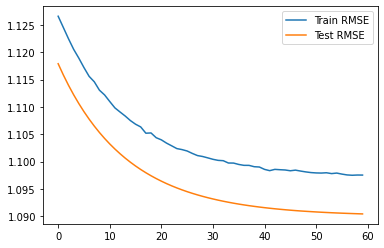

In [21]:
# PLOT
import matplotlib.pyplot as plt
plt.plot(result.history['RMSE'], label='Train RMSE')
plt.plot(result.history['val_RMSE'], label='Test RMSE')
plt.legend()
plt.show()

In [ ]:
user_ids = ratings_test.user_id.values[0:6]
movie_ids = ratings_test.movie_id.values[0:6]

predictions = model.predict([user_ids, movie_ids]) + mu

In [ ]:
print(ratings_test[0:6])

       user_id  movie_id  rating  timestamp
23307      468        51       3  875293386
36679       92       780       3  875660494
36626      555       489       5  879975455
83753      940        69       2  885921265
52604      181      1350       1  878962120
49877      320       195       5  884749255


In [ ]:
print(predictions)

[[3.555783 ]
 [3.472084 ]
 [3.5504608]
 [3.569458 ]
 [3.1841257]
 [3.5975978]]


In [ ]:
import numpy as np

def RMSE_np(y_true, y_pred):
  return np.sqrt(np.mean((np.array(y_true) - np.array(y_pred))**2))

In [ ]:
user_ids = ratings_test.user_id.values
movie_ids = ratings_test.movie_id.values

y_pred = model.predict([user_ids, movie_ids]) + mu

y_pred = np.ravel(y_pred,order='C') # 1차원 형태로 바꾸는 것 - order?

y_true = np.array(ratings_test.rating)

RMSE_np(y_true, y_pred)

1.0909831153232759

## 딥러닝을 적용한 추천 시스템

In [10]:
import pandas as pd

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dot, Add, Flatten
#layer 구성
from tensorflow.keras.layers import Dense, Concatenate, Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD, Adamax

In [3]:
r_cols = ['user_id','movie_id','rating','timestamp']
data_dic = '/content/drive/MyDrive/Recosys/Data/u.data'
ratings = pd.read_csv(data_dic,
                      names=r_cols,
                      sep='\t',
                      encoding='latin-1')

ratings_train, ratings_test = train_test_split(ratings, test_size=0.2, shuffle=True, random_state=2021)

In [4]:
# Define RMSE measure
def RMSE(y_true, y_pred):
  return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred))) # tensorfliw math 클래스 이용

# Variable 초기화 
k=200 # latent vec
mu = ratings_train.rating.mean() # 전체 평균
#  +1 은 bias term.의 크기 고려
# 다른데이터에서는 유니크한 개수 + 1 을 해줘야! 
M = ratings.user_id.max() + 1
N = ratings.movie_id.max() + 1 

### Keras Model


In [8]:
user = Input(shape=(1,))
item = Input(shape=(1,))

#embedding을 통해 각각 k개의 노드를 갖는 layer로 변환
P_embedding = Embedding(M,k,embeddings_regularizer=l2())(user)
Q_embedding = Embedding(N,k,embeddings_regularizer=l2())(item)

# 사용자 bias와 아이템 bias를 1개의 노드를 갖는 layer로 변환
user_bias = Embedding(M,1,embeddings_regularizer=l2())(user)
item_bias = Embedding(N,1,embeddings_regularizer=l2())(item)

In [11]:
P_embedding = Flatten()(P_embedding)
Q_embedding = Flatten()(Q_embedding)
user_bias = Flatten()(user_bias)
item_bias = Flatten()(item_bias)

R =  Concatenate()([P_embedding, Q_embedding,  user_bias, item_bias])

R = Dense(2048)(R)
R = Activation('linear')(R)

R = Dense(256)(R)
R = Activation('linear')(R)

R = Dense(1)(R)

model = Model(inputs=[user,item],outputs=R)

model.compile(loss=RMSE,
              optimizer=SGD(),
              metrics=[RMSE])

In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1, 200)       188800      ['input_5[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 1, 200)       336600      ['input_6[0][0]']                
                                                                                              

## Model Train

In [14]:
# 입력 데이터 정리
train_user_ids = ratings_train.user_id.values
train_movie_ids = ratings_train.movie_id.values
train_ratings = ratings_train.rating.values

test_user_ids = ratings_test.user_id.values
test_movie_ids = ratings_test.movie_id.values
test_ratings = ratings_test.rating.values

In [15]:
result = model.fit(x=[train_user_ids, train_movie_ids],
                   y= train_ratings - mu,
                   epochs = 65,
                   batch_size= 512,
                   validation_data=(
                       [test_user_ids, test_movie_ids],
                       test_ratings - mu
                   ))

Epoch 1/65
157/157 [==============================] - 17s 101ms/step - loss: 5.3849 - RMSE: 1.1265 - val_loss: 5.2421 - val_RMSE: 1.1176
Epoch 2/65
157/157 [==============================] - 16s 99ms/step - loss: 5.1240 - RMSE: 1.1251 - val_loss: 4.9893 - val_RMSE: 1.1158
Epoch 3/65
157/157 [==============================] - 17s 108ms/step - loss: 4.8788 - RMSE: 1.1230 - val_loss: 4.7520 - val_RMSE: 1.1141
Epoch 4/65
157/157 [==============================] - 16s 101ms/step - loss: 4.6489 - RMSE: 1.1212 - val_loss: 4.5290 - val_RMSE: 1.1125
Epoch 5/65
157/157 [==============================] - 12s 76ms/step - loss: 4.4326 - RMSE: 1.1203 - val_loss: 4.3196 - val_RMSE: 1.1108
Epoch 6/65
157/157 [==============================] - 11s 72ms/step - loss: 4.2295 - RMSE: 1.1179 - val_loss: 4.1230 - val_RMSE: 1.1091
Epoch 7/65
157/157 [==============================] - 11s 73ms/step - loss: 4.0384 - RMSE: 1.1159 - val_loss: 3.9378 - val_RMSE: 1.1071
Epoch 8/65
157/157 [=========================

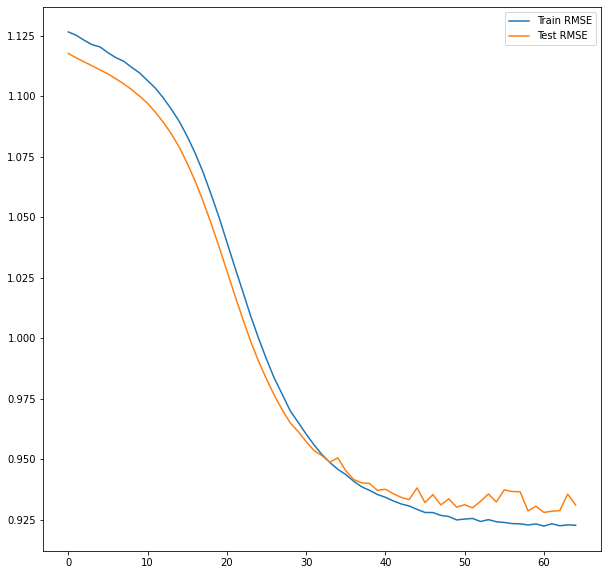

In [16]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.plot(result.history['RMSE'], label='Train RMSE')
plt.plot(result.history['val_RMSE'], label='Test RMSE')
plt.legend()
plt.show()

flucation 발생 -> 과적합


In [24]:
u_cols = ['user_id','age','sex','occupation','zip_code']
userdata_dic = '/content/drive/MyDrive/Recosys/Data/u.user'
users = pd.read_csv(userdata_dic,
                    names=u_cols,
                    sep='|',
                    encoding='latin-1')
users = users[['user_id','occupation']]

occupation = {}
def convert_occ(x):
  if x in occupation:
    return occupation[x]
  else:
    occupation[x] = len(occupation) # 새로운 값 저장하기(직업 인덱스 부여)
    return occupation[x]

users['occupation'] = users['occupation'].apply(convert_occ)

L = len(occupation)

train_occ = pd.merge(ratings_train, users, on='user_id')['occupation']
test_occ = pd.merge(ratings_test, users, on='user_id')['occupation']


# Variable 초기화 
k=200 # latent vec
mu = ratings_train.rating.mean() # 전체 평균
#  +1 은 bias term.의 크기 고려
# 다른데이터에서는 유니크한 개수 + 1 을 해줘야! 
M = ratings.user_id.max() + 1
N = ratings.movie_id.max() + 1 

user = Input(shape=(1,))
item = Input(shape=(1,))

P_embedding = Embedding(M,k,embeddings_regularizer=l2())(user)
Q_embedding = Embedding(N,k,embeddings_regularizer=l2())(item)

# 사용자 bias와 아이템 bias를 1개의 노드를 갖는 layer로 변환
user_bias = Embedding(M,1,embeddings_regularizer=l2())(user)
item_bias = Embedding(N,1,embeddings_regularizer=l2())(item)

P_embedding = Flatten()(P_embedding)
Q_embedding = Flatten()(Q_embedding)

user_bias = Flatten()(user_bias)
item_bias = Flatten()(item_bias)

occ = Input(shape=(1,))
OCC_embedding = Embedding(L,3,embeddings_regularizer=l2())(occ)
OCC_layer = Flatten()(OCC_embedding)

R = Concatenate()([P_embedding, Q_embedding, user_bias, item_bias, OCC_layer])

R = Dense(2048)(R)
R = Activation('linear')(R)
R = Dense(256)(R)
R = Activation('linear')(R)
R = Dense(1)(R)

model = Model(inputs=[user,item,occ],outputs=R)

model.compile(loss=RMSE,
              optimizer=SGD(),
              metrics=[RMSE])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_14 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_15 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 embedding_8 (Embedding)        (None, 1, 200)       188800      ['input_13[0][0]']               
                                                                                            

In [25]:
# 입력 데이터 정리
train_user_ids = ratings_train.user_id.values
train_movie_ids = ratings_train.movie_id.values
train_ratings = ratings_train.rating.values
train_occs = train_occ.values

test_user_ids = ratings_test.user_id.values
test_movie_ids = ratings_test.movie_id.values
test_ratings = ratings_test.rating.values
test_occs = test_occ.values


In [26]:
result = model.fit(x = [train_user_ids, train_movie_ids, train_occs],
                   y = train_ratings - mu,
                   epochs=65,
                   batch_size = 512,
                   validation_data=([test_user_ids, test_movie_ids, test_occs],
                                    test_ratings -mu))

Epoch 1/65
157/157 [==============================] - 18s 109ms/step - loss: 5.3986 - RMSE: 1.1267 - val_loss: 5.2555 - val_RMSE: 1.1176
Epoch 2/65
157/157 [==============================] - 16s 105ms/step - loss: 5.1368 - RMSE: 1.1246 - val_loss: 5.0020 - val_RMSE: 1.1159
Epoch 3/65
157/157 [==============================] - 17s 106ms/step - loss: 4.8910 - RMSE: 1.1231 - val_loss: 4.7640 - val_RMSE: 1.1143
Epoch 4/65
157/157 [==============================] - 17s 107ms/step - loss: 4.6603 - RMSE: 1.1222 - val_loss: 4.5405 - val_RMSE: 1.1128
Epoch 5/65
157/157 [==============================] - 16s 104ms/step - loss: 4.4435 - RMSE: 1.1206 - val_loss: 4.3304 - val_RMSE: 1.1112
Epoch 6/65
157/157 [==============================] - 17s 107ms/step - loss: 4.2397 - RMSE: 1.1178 - val_loss: 4.1331 - val_RMSE: 1.1096
Epoch 7/65
157/157 [==============================] - 16s 104ms/step - loss: 4.0482 - RMSE: 1.1164 - val_loss: 3.9476 - val_RMSE: 1.1077
Epoch 8/65
157/157 [=====================

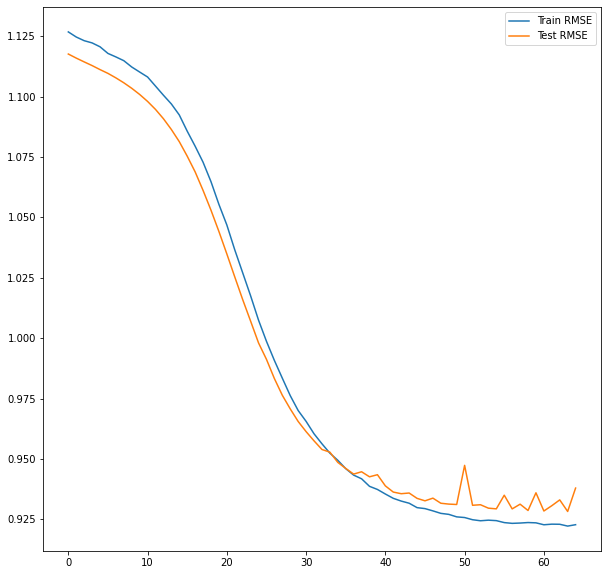

In [27]:
plt.figure(figsize=(10,10))
plt.plot(result.history['RMSE'], label='Train RMSE')
plt.plot(result.history['val_RMSE'], label='Test RMSE')
plt.legend()
plt.show()